<a href="https://www.kaggle.com/code/altarnolutarkan/convlstm-next-frame-predict?scriptVersionId=130985640" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt

In [2]:
src_path = '/kaggle/input/turkey-precip-img-archive'
length = len(os.listdir(src_path))

images = []
for i in range(length):
    img = Image.open(f'{src_path}/img{i}.png')
    img=img.crop((0,120,640,360))
    img=img.convert('RGB')
    img=img.resize((160,60),Image.Resampling.LANCZOS)
    img=np.array(img)/255
    img=img.reshape(60,160,3)
    images.append(img) 

In [3]:
def train_test(images,step_size,start,stop):
    seqx=[]
    seqy=[]
    x=[]
    y=[]
    
    sample_size=stop-start
    
    for i in range(start,stop):
        endx=i+step_size
        endy=i+step_size*2
        
        seqx.append(images[i:endx])
        seqy.append(images[endx:endy])

        x.append(np.array(seqx))
        y.append(np.array(seqy))
        
        seqx.clear()
        seqy.clear()

    return np.array(x).reshape(sample_size,step_size, 60, 160, 3),np.array(y).reshape(sample_size,step_size,60, 160, 3)

In [4]:
step_size = 3

import tensorflow as tf
with tf.device('/GPU:0'):
    xtrain,ytrain = train_test(images,step_size,0,800)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
xtest,ytest = train_test(images,step_size,900,990)
xval,yval = train_test(images,step_size,800,900)
print(f'train: x{xtrain.shape},y{ytrain.shape}  test: x{xtest.shape},y:{ytest.shape}')

train: x(800, 3, 60, 160, 3),y(800, 3, 60, 160, 3)  test: x(90, 3, 60, 160, 3),y:(90, 3, 60, 160, 3)


In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import ConvLSTM2D,BatchNormalization,Conv3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [7]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [8]:
def model():
    seq = Sequential()

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(step_size, 60, 160, 3),
                       padding='same', return_sequences=True,activation="relu"))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True,activation="relu"))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True,activation="relu"))
    seq.add(BatchNormalization())
    
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True,activation="relu"))
    #seq.add(BatchNormalization())

    seq.add(Conv3D(filters=3, kernel_size=(3, 3, 3),
                   activation='sigmoid',
                   padding='same', data_format='channels_last'))
    seq.compile(loss='mae', optimizer=Adam(learning_rate=0.001))
    
    return seq

m=model()
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 3, 60, 160, 40)    62080     
                                                                 
 batch_normalization (BatchN  (None, 3, 60, 160, 40)   160       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 3, 60, 160, 40)    115360    
                                                                 
 batch_normalization_1 (Batc  (None, 3, 60, 160, 40)   160       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 3, 60, 160, 40)    115360    
                                                                 
 batch_normalization_2 (Batc  (None, 3, 60, 160, 40)   1

In [9]:
#early_stopping = EarlyStopping(monitor="accuracy", patience=10)
#reduce_lr = ReduceLROnPlateau(monitor="accuracy", patience=5)

with tf.device('/GPU:0'):
    m.fit(xtrain,ytrain,epochs=15,batch_size=5,
    validation_data=(xval, yval))
    #callbacks=[early_stopping, reduce_lr])

Epoch 1/15


2023-05-25 13:48:09.810188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/sequential/conv_lstm2d_3/while/sequential/conv_lstm2d_3/while_grad/body/_743/input/_2035' -> 'gradient_tape/sequential/conv_lstm2d_3/while/sequential/conv_lstm2d_3/while_grad/body/_743/gradient_tape/sequential/conv_lstm2d_3/while/gradients/AddN', 'Func/gradient_tape/sequential/conv_lstm2d_2/while/sequential/conv_lstm2d_2/while_grad/body/_938/input/_2154' -> 'gradient_tape/sequential/conv_lstm2d_2/while/sequential/conv_lstm2d_2/while_grad/body/_938/gradient_tape/sequential/conv_lstm2d_2/while/gradients/AddN', 'Func/gradient_tape/sequential/conv_lstm2d_1/while/sequential/conv_lstm2d_1/while_grad/body/_1133/input/_2273' -> 'gradient_tape/sequential/conv_lstm2d_1/while/sequential/conv_lstm2d_1/while_grad/body/_1133/gradient_tape/sequential/conv_lstm2d_1/while/gradients/Add

160/160 [==============================] - ETA: 0s - loss: 0.0692

2023-05-25 13:48:44.579158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/convolution_7' -> 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/add_6', 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/mul_2' -> 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/add_5', 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/Relu_1' -> 'sequential/conv_lstm2d_3/while/body/_145/sequential/conv_lstm2d_3/while/mul_5', 'sequential/conv_lstm2d_2/while/body/_97/sequential/conv_lstm2d_2/while/mul_2' -> 'sequential/conv_lstm2d_2/while/body/_97/sequential/conv_lstm2d_2/while/add_5', 'sequential/conv_lstm2d_2/while/body/_97/sequential/conv_lstm2d_2/while/clip_by_value_2' -> 'sequential/conv_lstm2d_2/while/body/_97/seq

160/160 [==============================] - 42s 175ms/step - loss: 0.0692 - val_loss: 0.0366
Epoch 2/15
160/160 [==============================] - 26s 166ms/step - loss: 0.0534 - val_loss: 0.0357
Epoch 3/15
160/160 [==============================] - 27s 168ms/step - loss: 0.0526 - val_loss: 0.0251
Epoch 4/15
160/160 [==============================] - 26s 165ms/step - loss: 0.0518 - val_loss: 0.0232
Epoch 5/15
160/160 [==============================] - 27s 167ms/step - loss: 0.0515 - val_loss: 0.0231
Epoch 6/15
160/160 [==============================] - 27s 167ms/step - loss: 0.0511 - val_loss: 0.0227
Epoch 7/15
160/160 [==============================] - 27s 166ms/step - loss: 0.0507 - val_loss: 0.0230
Epoch 8/15
160/160 [==============================] - 26s 166ms/step - loss: 0.0507 - val_loss: 0.0253
Epoch 9/15
160/160 [==============================] - 27s 168ms/step - loss: 0.0505 - val_loss: 0.0226
Epoch 10/15
160/160 [==============================] - 27s 166ms/step - loss: 0.0504

1
1/1 [==============================] - 1s 853ms/step


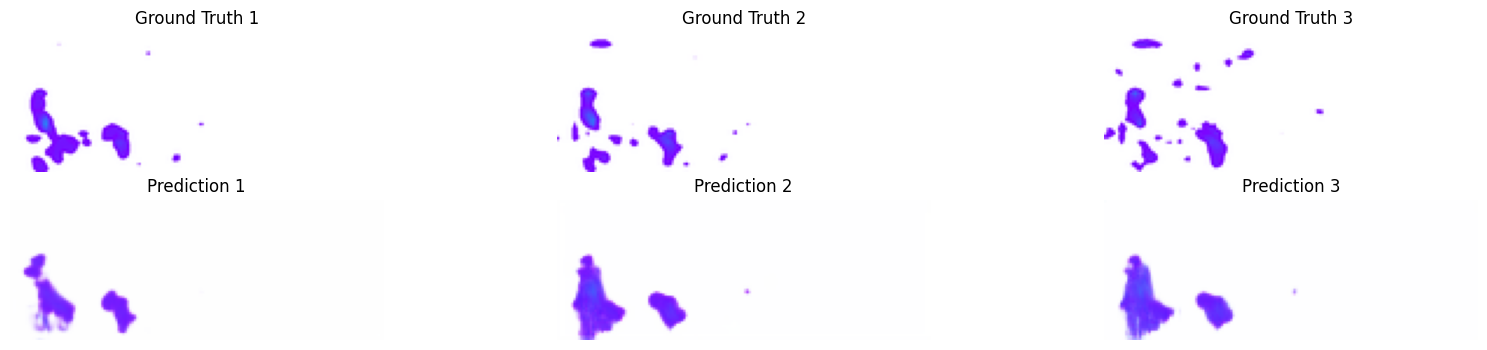

In [10]:
def predictions(model,xtest,ytest):
    choice = np.random.choice(len(xtest))
    print(choice)
    pre = model.predict(xtest[choice].reshape(1,step_size, 60, 160, 3))
    pre=pre*255

    fig, axes = plt.subplots(2, 3, figsize=(20, 4))

    for time, ax in enumerate(axes[0]):
        ax.imshow(np.squeeze(ytest[choice][time]))
        
        ax.set_title(f"Ground Truth {time+1}")
        ax.axis("off")

    for time, ax in enumerate(axes[1]):
        im=Image.fromarray(np.uint8(pre[0][time]),'RGB')
        ax.imshow(im)
        ax.set_title(f"Prediction {time+1}")
        ax.axis("off")

predictions(m,xtest,ytest)

In [11]:
m.save('model_weights')

from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/model_weights')

53
1/1 [==============================] - 1s 820ms/step


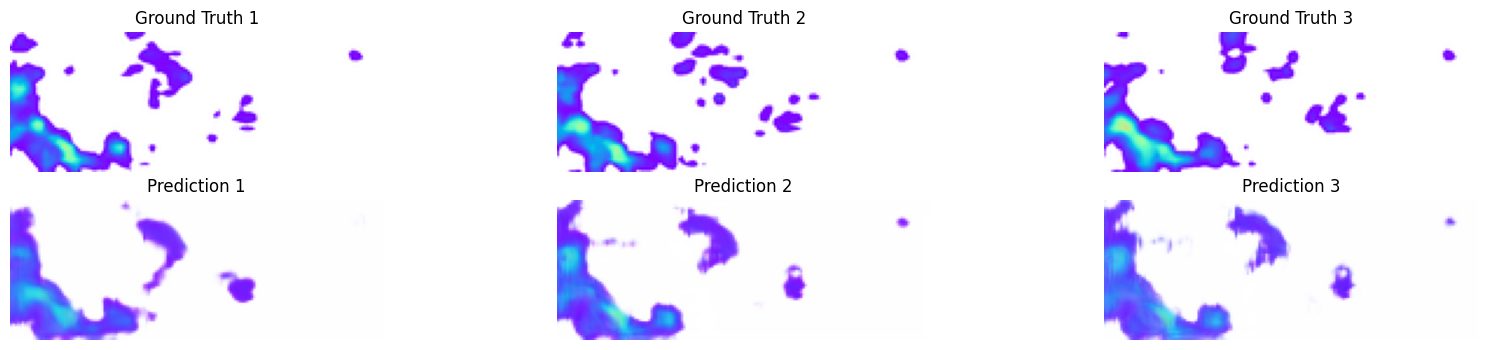

In [12]:
predictions(model,xtest,ytest)